# Processing images with oBIF

In [233]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.signal import convolve2d
from PIL import Image
from collections import Counter
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


## Filters

Firstly, we need to implement some filters that will be used by the mtBif class for generating the directions of the image. Mainly, we will use the Gaussian Derivative of 0th, 1st and 2nd order

In [234]:
def mtDownsampleFilter(inFilter, scaleFactor):
    """
    mtDownsampleFilter
    Downsamples a 1D filter by averaging across scaleFactor bins.

    Parameters:
    - inFilter (1D array): Input filter to be downsampled
    - scaleFactor (int): Factor by which to downsample the input filter. Defines the
                        number of bins to average over and collapse
                        into a single bin in the output filter

    Returns:
    - outFilter (1D array): Downsampled filter

    Usage: outFilter = mtDownsampleFilter(inFilter, scaleFactor)
    """
    numBins = len(inFilter)
    outSize = numBins // scaleFactor
    outFilter = np.zeros(outSize)

    for i in range(outSize):
        outFilter[i] = np.mean(inFilter[i * scaleFactor : (i + 1) * scaleFactor])

    return outFilter


In [235]:
def mtGaussianDerivativeFilter1d_s0(x, sigma):
    """
    mtGaussianDerivativeFilter1d_s0
    Generate discrete zeroth-order 1D Gaussian Derivative filter

    Parameters:
    - x (1D array): array of x values
    - sigma (float): Standard deviation of Gaussian used to generate filter

    Returns:
    - s0 (1D array): zeroth order 1D filter

    Usage: s0 = mtGaussianDerivativeFilter1d_s0(x, sigma)
    """
    Cs = 1 / (np.sqrt(2 * np.pi) * sigma)
    s0 = Cs * np.exp(-(x**2) / (2 * sigma**2))
    return s0

def mtGaussianDerivativeFilter1d_s1(x, sigma):
    """
    mtGaussianDerivativeFilter1d_s1
    Generate discrete first-order 1D Gaussian Derivative filter

    Parameters:
    - x (1D array): array of x values
    - sigma (float): Standard deviation of Gaussian used to generate filter

    Returns:
    - s1 (1D array): first order 1D filter

    Usage: s1 = mtGaussianDerivativeFilter1d_s1(x, sigma)
    """
    s0 = mtGaussianDerivativeFilter1d_s0(x, sigma)
    s1 = (x / (sigma**2)) * s0
    return s1

def mtGaussianDerivativeFilter1d_s2(x, sigma):
    """
    mtGaussianDerivativeFilter1d_s2
    Generate discrete second-order 1D Gaussian Derivative filter

    Parameters:
    - x (1D array): array of x values
    - sigma (float): Standard deviation of Gaussian used to generate filter

    Returns:
    - s2 (1D array): second order 1D filter

    Usage: s2 = mtGaussianDerivativeFilter1d_s2(x, sigma)
    """
    s0 = mtGaussianDerivativeFilter1d_s0(x, sigma)
    s2 = ((x**2 - sigma**2) / (sigma**4)) * s0
    return s2

def mtGaussianDerivativeFilters1d(sigma):
    """
    mtGaussianDerivativeFilters1d
    Generates discrete zeroth, first, and second order 1D Gaussian Derivative filters

    Parameters:
    - sigma (float): Standard deviation of Gaussian used to generate filters

    Internal parameters:
    - scaleFactor: Number of bins in higher resolution filter for each bin in
                   original resolution filter
    - widthMulti: Filters are centered on the middle bin. The extent of the filter
                  either side of this central pixel is widthMulti standard deviations

    Returns:
    - s0 (1D array): zeroth order 1D filter
    - s1 (1D array): first-order 1D filter
    - s2 (1D array): second-order 1D filter

    Usage: s0, s1, s2 = mtGaussianDerivativeFilters1d(sigma)
    """

    # Force numeric parameters to be float to avoid errors
    sigma = float(sigma)

    scaleFactor = 10
    widthMulti = 5
    halfWidth = (np.ceil(sigma) * widthMulti) + 1

    # Set x values for each bin of high resolution filter. Note that the x limits
    # are the same, we just generate more bins between them
    xHighRes = np.arange(-halfWidth, halfWidth + 1, 1 / scaleFactor)

    # Zeroth order filter
    s0HighRes = mtGaussianDerivativeFilter1d_s0(xHighRes, sigma)
    s0 = mtDownsampleFilter(s0HighRes, scaleFactor)
    # First-order filter
    s1R = mtGaussianDerivativeFilter1d_s1(xHighRes, sigma)
    s1 = mtDownsampleFilter(s1R, scaleFactor)
    # Second-order filter
    s2R = mtGaussianDerivativeFilter1d_s2(xHighRes, sigma)
    s2 = mtDownsampleFilter(s2R, scaleFactor)

    return s0, s1, s2


In [236]:
def mtSeparableFilter2(xFilter, yFilter, input, mode="mirror"):
    """
    mtSeparableFilter2
    Performs 2D filtering of a 2D matrix input by a separable 2D filter by
    filtering by the x and y filter components in turn and combining the results

    Parameters:
    - xFilter (1D array): 1D filter comprising the x-component of a separable 2D filter
    - yFilter (1D array): 1D filter comprising the y-component of a separable 2D filter
    - input (2D array): The 2D input matrix to be filtered
    - mode (str): The filter mode. Options are:
        - 'cyclic': Returns an output the same size and the input. The input is
                    extended in x and y prior to filtering, with the extended boundaries
                    filled with pixels "wrapped round" from the opposite edge of the input
        - 'mirror': Returns an output the same size and the input. The input is
                    extended in x and y, prior to filtering, with the extended boundaries
                    filled with pixels "reflected" from the edge of the input.
        - Any other valid "mode" argument to SciPy's convolve2d function. These
                    options will all extend the image in x and y prior to filtering, with the
                    extended boundaries filled according to the mode.
                    For more information, see the documentation of SciPy's convolve2d function.

    Returns:
    - output (2D array): Filtered output (same size as input)
    """
    
    # Check x and y filters are 1D vectors
    if xFilter.ndim != 1 or yFilter.ndim != 1:
        raise ValueError("x and y filters must be 1D vectors")
    # Check x and y filters have an odd length
    if len(xFilter) % 2 == 0 or len(yFilter) % 2 == 0:
        raise ValueError("x and y filters must be of odd length")

    # Ensure x is a row vector and y is a column vector
    xFilter = np.reshape(xFilter, (1, len(xFilter)))
    yFilter = np.reshape(yFilter, (len(yFilter), 1))

    if mode.lower() == "cyclic":
        # If cyclic mode selected, extend image in x (for x filter pass) and y (for y filter pass)
        # and fill extended padding with pixels from opposite side of image.
        # Using convolve2d in 'valid' mode on the padded image returns an output with the same dimensions as the unpadded input image.
        xOut = convolve2d(
            input, np.flip(xFilter, axis=1), mode="valid", boundary="wrap"
        )
        output = convolve2d(
            xOut, np.flip(yFilter, axis=0), mode="valid", boundary="wrap"
        )
    elif mode.lower() == "mirror":
        # If mirror mode selected, extend image in x (for x filter pass) and y (for y filter pass)
        # and fill extended padding with reflected boundary pixels.
        # Using convolve2d in 'valid' mode on the padded image returns an output with the same dimensions as the unpadded input image.
        xOut = convolve2d(
            input, np.flip(xFilter, axis=1), mode="valid", boundary="symm"
        )
        output = convolve2d(
            xOut, np.flip(yFilter, axis=0), mode="valid", boundary="symm"
        )
    else:
        # Otherwise just apply convolve2d for x and y filters, passing selected mode
        # Modes supported by convolve2d are:
        # 'same' - (default) returns the central part of the correlation that is the same size as the image.
        # 'valid' - returns only those parts of the correlation that are computed without the zero-padded edges, size(output) < size(image).
        # 'full' - returns the full 2-D correlation, size(output) > size(image).
        output = convolve2d(
            convolve2d(input, xFilter, mode=mode, boundary="fill"),
            yFilter,
            mode=mode,
            boundary="fill",
        )

    return output


In [237]:
def mtFilter2d(xyFilter, input, mode, method=None):
    """
    Performs 2D filtering of a 2D matrix input by a 2D filter

    Parameters:
    - xyFilter: 2D filter. Filter must be of odd size in both dimensions (and therefore have a centre pixel)
    - input: The 2D input matrix to be filtered
    - mode: The filter mode. Options are:
        - 'cyclic': Returns an output the same size and the input. The input is extended in x and y prior to filtering, 
                    with the extended boundaries filled with pixels "wrapped round" from the opposite edge of the input
        - 'mirror': Returns an output the same size as the input. The input is extended in x and y, prior to filtering, 
                    with the extended boundaries filled with pixels "reflected" from the edge of the input.
        - 'valid': Performs a 'valid' filter operation (i.e. no filtered values for border pixels, but returns an 
                    output the same size as the input by padding the valid output with NaN
    - method: Method to use to perform filtering operation. Optional. If not provided, defaults to 'conv2'
        - 'conv2': use built-in SciPy convolve2d method
        - 'convolve2': Not available in SciPy. Would require a third-party library or implementation
        - 'convnfft': Not available in SciPy. Would require a third-party library or implementation

    Returns:
    - output: Filtered output. Same size as input.
    """

    if method is None:
        method = 'conv2'


    height, width = xyFilter.shape
    # check filter is odd in both dimensions (therefore has a centre pixel)
    if not np.all(np.mod([width, height], 2) == 1):
        raise ValueError('filter must have dimensions of odd length')

    xPad = (width - 1) // 2
    yPad = (height - 1) // 2
    rawMode = 'valid'
    postPadNans = False  # Used for 'padded' mode

    # If custom mode, amend image and mode then apply filter2/conv2
    if mode.lower() == 'cyclic':
        # If cyclic mode selected, extend image in x and y and fill extended padding
        # with pixels from opposite side of image. Using filter2 in 'valid' mode on the
        # padded image returns an output with the same dimensions as the unpadded input
        # image.
        input = np.pad(input, ((yPad, yPad), (xPad, xPad)), mode='wrap')
    elif mode.lower() == 'mirror':
        # If mirror mode selected, extend image in x and y and fill extended padding
        # with reflected boundary pixels. Using filter2 in 'valid' mode on the padded
        # image returns an output with the same dimensions as the unpadded input image.
        input = np.pad(input, ((yPad, yPad), (xPad, xPad)), mode='reflect')
    elif mode.lower() == 'padded':
        postPadNans = True

    # Perform correlation by flipping filter and doing convolution
    if method.lower() == 'conv2':
        output = convolve2d(input, np.flip(xyFilter), mode=rawMode)
    else:
        raise ValueError('Invalid method argument.')

    if postPadNans:
        output = np.pad(output, ((yPad, yPad), (xPad, xPad)), mode='constant', constant_values=np.nan)

    return output


## oBIF class

We will create a class for oBIF objects. This means that we are going to process the image provided and transform it into an image of directions, using the previously defined filters. Also, when displaying this object, we have assigned each direction with a color and it will be displayed as a colour map.

In [238]:
class mtBifs:
    def __init__(self, inputImage, blurWidth, flatnessThreshold):
        # Convert color image to grayscale if needed
        if len(inputImage.shape) == 3:
            inputImage = cv2.cvtColor(inputImage, cv2.COLOR_BGR2GRAY)

        # Rename input parameters to terms used in BIF papers
        # Force numeric parameters to be floats to avoid mixing integers and floats
        self.sigma = float(blurWidth)
        self.gamma = float(flatnessThreshold)

        # Generate filter responses
        self.L, Lx, Ly, Lxx, Lyy, Lxy = self.dtgFilterResponsesFromImage(inputImage, self.sigma)

        # Generate and set BIF classes
        self.Class = self.bifClassesFromFilterResponses(
            self.sigma, self.gamma, self.L, Lx, Ly, Lxx, Lyy, Lxy
        )

        # Generate and set BIF orientations
        self.Vx, self.Vy = self.bifOrientationsFromFilterResponses(
            self.L, Lx, Ly, Lxx, Lyy, Lxy
        )


    @staticmethod
    def dtgFilterResponsesFromImage(inputImage, sigma):
        # Generate the 1D Gaussian Derivative filters used to calculate BIFs
        # s0 = zeroth order 1D filter
        # s1 = first-order 1D filter
        # s2 = second-order 1D filter
        s0, s1, s2 = mtGaussianDerivativeFilters1d(sigma)

        # Calculate 2D filter responses over the image using the 1D filters
        # Pad extended boundary so filter response is same size as input
        # image and pad boundary with reflected edge pixels
        filterMode = "mirror"
        # zeroth order filter
        L = mtSeparableFilter2(s0, s0, inputImage, filterMode)
        # first-order in x, zeroth in y
        Lx = mtSeparableFilter2(s1, s0, inputImage, filterMode)
        # first-order in y, zeroth in x
        Ly = mtSeparableFilter2(s0, s1, inputImage, filterMode)
        # second-order in x, zeroth in y
        Lxx = mtSeparableFilter2(s2, s0, inputImage, filterMode)
        # second-order in y, zeroth in x
        Lyy = mtSeparableFilter2(s0, s2, inputImage, filterMode)
        # first-order in x and y
        Lxy = mtSeparableFilter2(s1, s1, inputImage, filterMode)

        return L, Lx, Ly, Lxx, Lyy, Lxy

    @staticmethod
    def bifClassesFromFilterResponses(sigma, gamma, L, Lx, Ly, Lxx, Lyy, Lxy):
        # Compute BIF classes
        numBifClasses = 7
        numYs, numXs = L.shape
        jetScore = np.zeros((numYs, numXs, numBifClasses))

        # 1: flat (pink)
        jetScore[:, :, 0] = gamma * L
        # 2: gradient (grey)
        jetScore[:, :, 1] = sigma * np.sqrt(Lx**2 + Ly**2)

        # Second order BIFs are calculated from Hessian eigenvalues.
        # The formulation below has been chosen to be numerically stable
        # as some issues were encountered due to numerical precision
        # issues when using some other formulations.
        eigVal1 = (Lxx + Lyy + np.sqrt((Lxx - Lyy) ** 2 + 4 * Lxy**2)) / 2
        eigVal2 = (Lxx + Lyy - np.sqrt((Lxx - Lyy) ** 2 + 4 * Lxy**2)) / 2

        # 3: dark blob (black)
        jetScore[:, :, 2] = sigma**2 * (eigVal1 + eigVal2) / 2
        # 4: light blob (white)
        jetScore[:, :, 3] = -(sigma**2) * (eigVal1 + eigVal2) / 2
        # 5: dark line (blue)
        jetScore[:, :, 4] = sigma**2 * eigVal1 / np.sqrt(2)
        # 6: light line (yellow)
        jetScore[:, :, 5] = -(sigma**2) * eigVal2 / np.sqrt(2)
        # 7: saddle (green)
        jetScore[:, :, 6] = sigma**2 * (eigVal1 - eigVal2) / 2

        # Get maximum BIF score at each pixel (index in third dimension
        # corresponds to integer code for BIF class)
        bifClasses = np.argmax(jetScore, axis=2) + 1

        return bifClasses

    def bifOrientationsFromFilterResponses(self, L, Lx, Ly, Lxx, Lyy, Lxy):
        # Compute unit vector orientations for first order BIF classes
        vx1 = Lx
        vy1 = Ly
        norm1 = np.sqrt(vx1**2 + vy1**2)
        vx1 = np.divide(vx1, norm1, out=np.zeros_like(vx1), where=norm1 != 0)
        vy1 = np.divide(vy1, norm1, out=np.zeros_like(vy1), where=norm1 != 0)

        # Compute unit vector orientations for second order BIF classes
        vx2 = -(-Lxx + Lyy + np.sqrt((Lxx - Lyy) ** 2 + 4 * Lxy**2)) / (2 * Lxy)
        vy2 = np.ones_like(vx2)
        norm2 = np.sqrt(vx2**2 + vy2**2)
        vx2 = np.divide(vx2, norm2, out=np.zeros_like(vx2), where=norm2 != 0)
        vy2 = np.divide(vy2, norm2, out=np.zeros_like(vy2), where=norm2 != 0)

        # Handle cases where Lxy is zero
        vertMask = Lxx > Lyy
        horzMask = Lyy > Lxx
        zero_mask = Lxy == 0
        vx2[zero_mask & vertMask] = 0
        vy2[zero_mask & vertMask] = 1
        vx2[zero_mask & horzMask] = 1
        vy2[zero_mask & horzMask] = 0

        # Handle light ridges
        lightMask2 = self.Class == 6
        vx2Old = vx2.copy()
        vy2Old = vy2.copy()
        vx2[lightMask2] = vy2Old[lightMask2]
        vy2[lightMask2] = -vx2Old[lightMask2]

        # Assign orientations to output variables
        vx = np.where(self.Class == 2, vx1, vx2)
        vy = np.where(self.Class == 2, vy1, vy2)

        # Another approach to assigning orientations
        # vx = np.zeros_like(vx1)
        # vy = np.zeros_like(vy1)

        # mask1 = self.Class == 2
        # vx[mask1] = vx1[mask1]
        # vy[mask1] = vy1[mask1]

        # mask2 = (self.Class >= 5) & (self.Class <= 7)
        # vx[mask2] = vx2[mask2]
        # vy[mask2] = vy2[mask2]

        return vx, vy


    @staticmethod
    def colourMap():
        # Generates colour map for use when displaying BIFs
        #
        # OUTPUTS:
        # colourMap: Follows the format of built-in Matlab colour maps. Row N+1 defines
        #            the RGB colour to display for matrix elements with value N. Colours
        #            as per the BIF journal papers from Crosier and Griffin with the
        #            addition of mapping for value 0 in row 1. This is not a valid BIF
        #            class but is required for a valid colour map.
        #               0 = invalid (cyan)
        #               1 = falt (pink)
        #               2 = gradient (grey)
        #               3 = dark blob (black)
        #               4 = light blob (white)
        #               5 = dark line (blue)
        #               6 = light line (yellow)
        #               7 = saddle (green)
        #
        # USAGE: colourMap = mtBifs.colourMap()

        # Define color map for displaying BIFs
        bif_cyan = [0, 0.5, 0.5]
        bif_pink = [1, 0.7, 0.7]
        bif_grey = [0.6, 0.6, 0.6]
        bif_black = [0, 0, 0]
        bif_white = [1, 1, 1]
        bif_blue = [0.1, 0.1, 1]
        bif_yellow = [0.9, 0.9, 0]
        bif_green = [0, 1, 0]

        return np.array(
            [
                bif_cyan,
                bif_pink,
                bif_grey,
                bif_black,
                bif_white,
                bif_blue,
                bif_yellow,
                bif_green,
            ]
        )

    @staticmethod
    def drawBifDir2d(self, x, y, xScale, yScale, lineWidth, bifClass, vx, vy):
        
        # Draw BIF orientation marks
        if bifClass in [0, 1, 3, 4]:
            return  # Do nothing. No direction associated with these BIF classes

        X1 = [x - (xScale * 0.5) * vx, x + (xScale * 0.5) * vx]
        Y1 = [y - (yScale * 0.5) * vy, y + (yScale * 0.5) * vy]

        if bifClass == 2:
            X1 = [x, x + (xScale * 0.5) * vx]
            Y1 = [y, y + (yScale * 0.5) * vy]
            X2 = [x - (xScale * 0.5) * vx, x]
            Y2 = [y - (yScale * 0.5) * vy, y]
            plt.plot(X1, Y1, color="w", linewidth=lineWidth)
            plt.plot(X2, Y2, color="k", linewidth=lineWidth)
        elif bifClass == 5:
            plt.plot(X1, Y1, color="k", linewidth=lineWidth)
        elif bifClass == 6:
            plt.plot(X1, Y1, color="w", linewidth=lineWidth)
        elif bifClass == 7:
            X2 = [x - (xScale * 0.5) * vy, x + (xScale * 0.5) * vy]
            Y2 = [y + (yScale * 0.5) * vx, y - (yScale * 0.5) * vx]
            plt.plot(X1, Y1, color="k", linewidth=lineWidth)
            plt.plot(X2, Y2, color="w", linewidth=lineWidth)
    
    def getSnippet(self, rows, cols):
        """
        Creates a new mtBifs object with BIF data for specified rows and columns

        Args:
            rows (slice or list or numpy.ndarray): Rows for which to get BIF data
            cols (slice or list or numpy.ndarray): Columns for which to get BIF data

        Returns:
            mtBifs: mtBifs object containing BIF data for specified rows and columns
        """
        bifSnippet = mtBifs.__new__(mtBifs)  # Create a new mtBifs object
        bifSnippet.sigma = self.sigma  # Copy sigma value
        bifSnippet.gamma = self.gamma  # Copy gamma value

        # Convert rows and cols to numpy arrays if they are not already
        rows = np.asarray(rows)
        cols = np.asarray(cols)

        # Slice and copy relevant portions of Class, Vx, and Vy arrays
        bifSnippet.Class = self.Class[rows, cols]
        bifSnippet.Vx = self.Vx[rows, cols]
        bifSnippet.Vy = self.Vy[rows, cols]

        return bifSnippet

    def show(self, showOrientation=False):
        # Set BIF class colour map
        bifMap = self.colourMap()

        # Set all elements with invalid BIF classes to 0
        minValidBifClass = 1
        maxValidBifClass = 7
        bifClasses = self.Class.copy()
        bifClasses[
            (bifClasses < minValidBifClass) | (bifClasses > maxValidBifClass)
        ] = 0

        # Show BIF classes with colour map
        bifImage = bifMap[bifClasses]

        # Add direction marks if requested
        if showOrientation:
            numRows, numCols = self.Class.shape
            scale = 0.6
            lineWidth = 2
            for r in range(numRows):
                for c in range(numCols):
                    self.drawBifDir2d(
                        self,
                        c,
                        r,
                        scale,
                        scale,
                        lineWidth,
                        self.Class[r, c],
                        self.Vx[r, c],
                        self.Vy[r, c],
                    )

        return bifImage
    def generate_histogram(self):
        """
        Generates the oBIF histogram for the current mtBifs object.

        Returns:
            numpy.ndarray: The oBIF histogram.
        """
        # Initialize histogram bins
        num_bins = 23  # From the given formula 5n + 3
        histogram = np.zeros(num_bins)

        # Iterate over each pixel in the image
        for row in range(self.Class.shape[0]):
            for col in range(self.Class.shape[1]):
                # Determine the orientation bin index based on oBIF orientation and class
                if self.Class[row, col] == 1:  # pink class
                    continue
                elif self.Class[row, col] == 2:  # Gray class
                    orientation = (
                        np.arctan2(self.Vy[row, col], self.Vx[row, col]) / np.pi
                    )
                    if orientation > 0.75:
                        bin_index = 2  # 1st quadrant
                    elif orientation > 0.5:
                        bin_index = 3  # 2nd quadrant
                    elif orientation > 0.25:
                        bin_index = 4  # 3rd quadrant
                    elif orientation > 0:
                        bin_index = 5  # 4th quadrant
                    elif orientation > -0.25:
                        bin_index = 6  # 5th quadrant
                    elif orientation > -0.5:
                        bin_index = 7  # 6th quadrant
                    elif orientation > -0.75:
                        bin_index = 8  # 7th quadrant
                    else:
                        bin_index = 9  # 8th quadrant
                elif self.Class[row, col] == 3:  # black class
                    bin_index = 10
                elif self.Class[row, col] == 4:  # white class
                    bin_index = 11
                elif self.Class[row, col] == 5:  # Blue class
                    orientation = (
                        np.arctan2(self.Vy[row, col], self.Vx[row, col]) / np.pi
                    )
                    if orientation > 0.5:
                        bin_index = 12  # 1st quadrant
                    elif orientation > 0:
                        bin_index = 13  # 2nd quadrant
                    elif orientation > -0.5:
                        bin_index = 14  # 3rd quadrant
                    else:
                        bin_index = 15  # 4th quadrant
                elif self.Class[row, col] == 6:  # Yellow class
                    orientation = (
                        np.arctan2(self.Vy[row, col], self.Vx[row, col]) / np.pi
                    )
                    if orientation > 0.5:
                        bin_index = 16  # 1st quadrant
                    elif orientation > 0:
                        bin_index = 17  # 2nd quadrant
                    elif orientation > -0.5:
                        bin_index = 18  # 3rd quadrant
                    else:
                        bin_index = 19  # 4th quadrant
                elif self.Class[row, col] == 7:  # Green class
                    orientation = (
                        np.arctan2(self.Vy[row, col], self.Vx[row, col]) / np.pi
                    )
                    if orientation > 0.5:
                        bin_index = 20  # 1st quadrant
                    elif orientation > 0:
                        bin_index = 21  # 2nd quadrant
                    elif orientation > -0.5:
                        bin_index = 22  # 3rd quadrant
                    else:
                        bin_index = 23  # 4th quadrant
                else:  #  invalid classes
                    bin_index = 0

                # Increment the corresponding bin in the histogram
                histogram[bin_index] += 1

        # Normalize the histogram
        histogram /= np.sum(histogram)

        return histogram



## Plot images
We have plotted the original image with the processed one

In [239]:
def mtShowCaseBifs(title_text, image, bifs, zoom_rows, zoom_cols):
    """
    mtShowCaseBifs
    Displays image and BIFs for visual inspection. Three panels are shown as follows:
    - Left: entire input
    - Middle: BIF classes for entire image
    - Right: BIF classes and orientations for the specified rows and columns

    Parameters:
    - title_text (str): Text to display in figure window
    - image (numpy.ndarray): Input image for which BIFs have been calculated
    - bifs (mtBifs object): Object with BIF classes and orientations for entire image
    - zoom_rows (list): Rows to zoom in and show BIF orientations for
    - zoom_cols (list): Columns to zoom in and show BIF orientations for

    NOTE: It is recommended to show orientations only for small image areas
    (say up to about 50x50 pixels). For larger areas, it can be hard to
    distinguish the orientations and image display features tend to get a bit slow.

    Usage: mtShowCaseBifs(title_text, image, bifs, zoom_rows, zoom_columns)
    """

    # Open figure
    plt.figure(title_text, figsize=(12, 8))

    # Show test image
    plt.subplot(2, 2, 1)
    num_dims = len(image.shape)
    if num_dims == 2:
        # Convert greyscale image to RGB image
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image)
    plt.xlabel("Test image")

    # Show BIF classes for whole image
    plt.subplot(2, 2, 2)
    bif_image = bifs.show()
    plt.imshow(bif_image)
    plt.xlabel("BIF class for all pixels")

    # Show test image
    plt.subplot(2, 2, 3)
    plt.imshow(image[zoom_rows[:, np.newaxis], zoom_cols])
    plt.xlabel("Image for zoomed area")
        
    # Show BIF classes and orientation for zoomed pixel(s)
    plt.subplot(2, 2, 4)
    snippet = bifs.getSnippet(zoom_rows[:, np.newaxis], zoom_cols).show(showOrientation=True)
    plt.imshow(snippet)
    plt.xlabel('BIF class and orientation\nfor zoomed area')

    plt.show()


In [240]:
from sklearn.metrics import accuracy_score

def train_svm(histogram_f1,histogram_f2,histogram_f3,histogram_f4, histogram_m1,histogram_m2,histogram_m3,histogram_m4, labels):
    """
    Trains an SVM using the provided histogram and labels.
    Args:
        histogram_f (numpy.ndarray): The oBIF histogram for female image.
        histogram_m (numpy.ndarray): The oBIF histogram for male image.
        labels (list): The corresponding labels.
    Returns:
        sklearn.svm.SVC: The trained SVM model.
    """
    X = np.vstack([histogram_f1,histogram_f2,histogram_f3,histogram_f4, histogram_m1,histogram_m2,histogram_m3,histogram_m4])
    y = labels  # use the passed labels

    # Create an SVM with RBF kernel
    clf = svm.SVC(kernel='rbf', C=10, gamma='scale')

    # Train the SVM
    clf.fit(X, y)

    # Predict the labels for the training data
    y_pred = clf.predict(X)

    # Calculate the accuracy of the model on the training data
    accuracy = accuracy_score(y, y_pred)
    print('Training accuracy:', accuracy)

    return clf

In [241]:
def test_svm(clf, histograms_test, labels_test):
    """
    Tests the trained SVM model on the provided test data.
    Args:
        clf (sklearn.svm.SVC): The trained SVM model.
        histograms_test (list of numpy.ndarray): The oBIF histograms for test images.
        labels_test (list): The corresponding labels for test data.
    Returns:
        float: The accuracy of the model on the test data.
    """
    histograms_test_stacked = np.vstack(histograms_test)
    y_pred = clf.predict(histograms_test_stacked)
    accuracy = accuracy_score(labels_test, y_pred)
    print('Test accuracy:', accuracy)
    return accuracy

## Try it out

We have implemented a function to demonstrate the oBif images

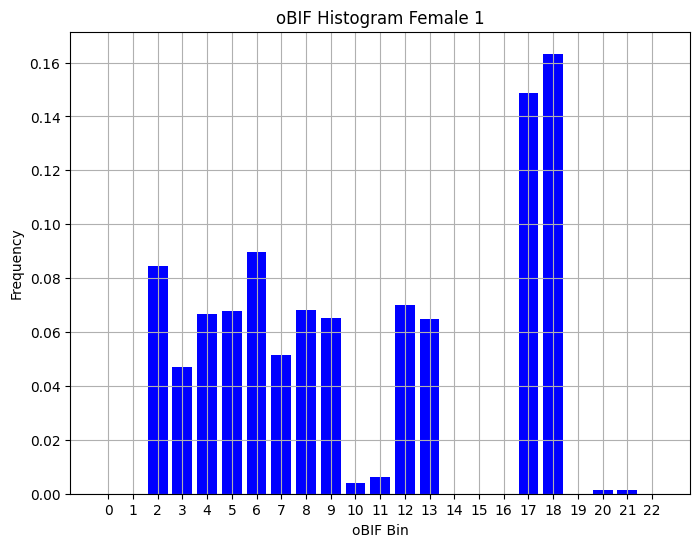

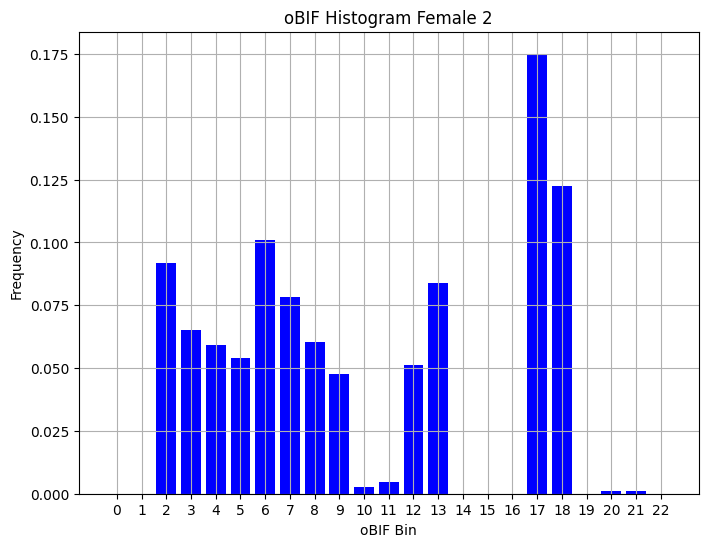

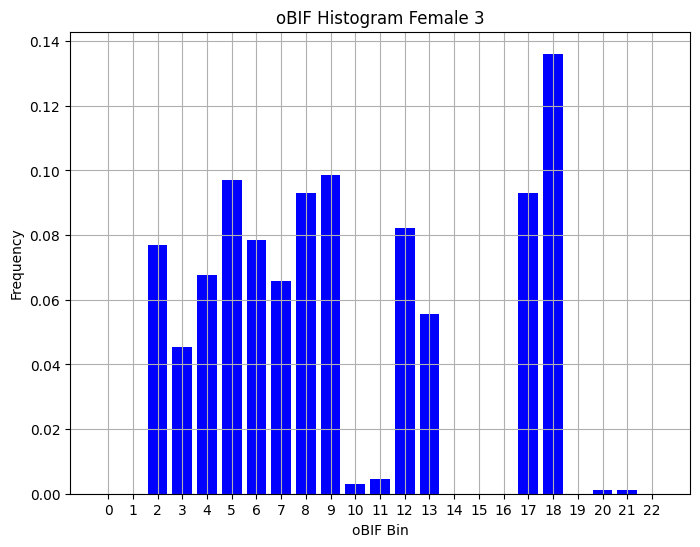

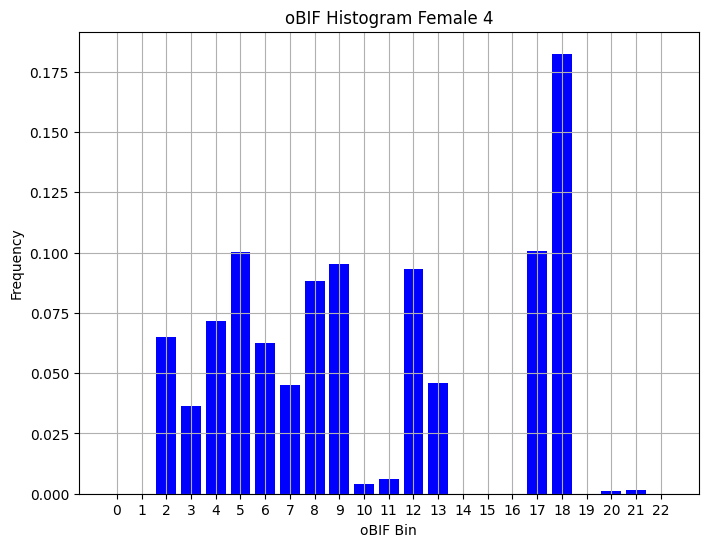

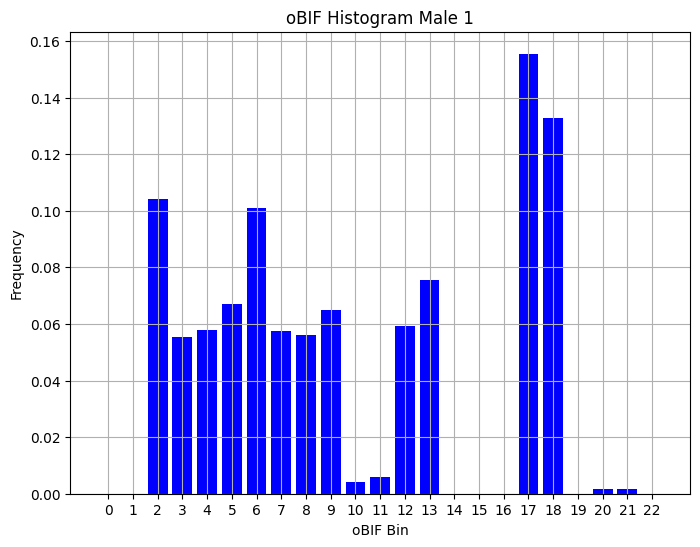

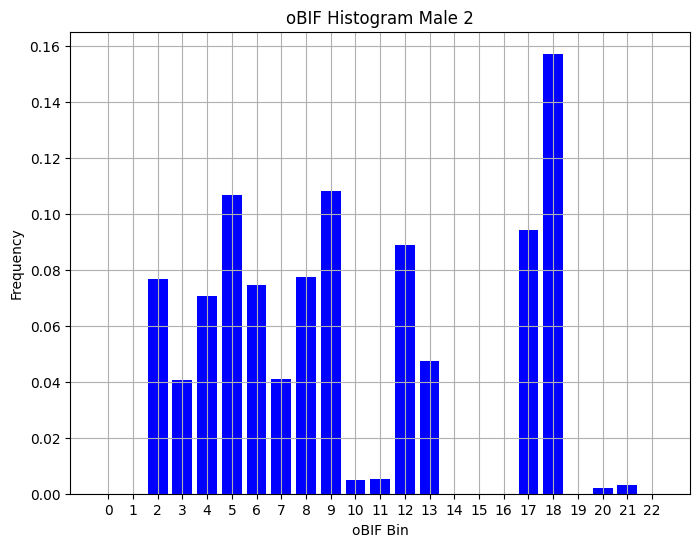

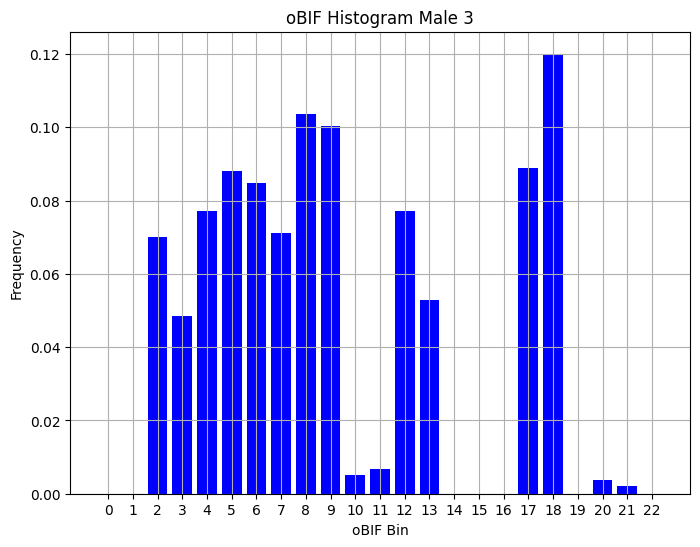

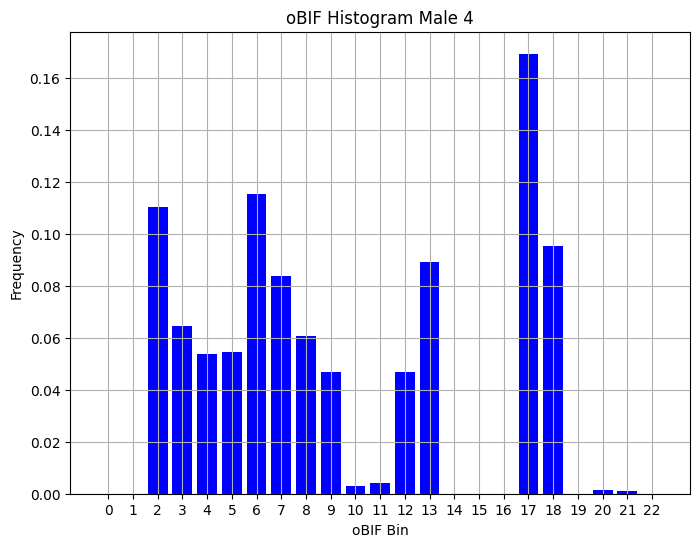

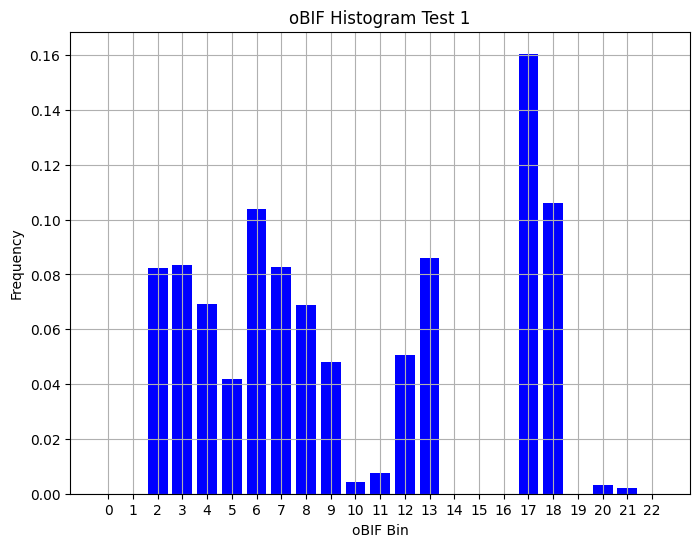

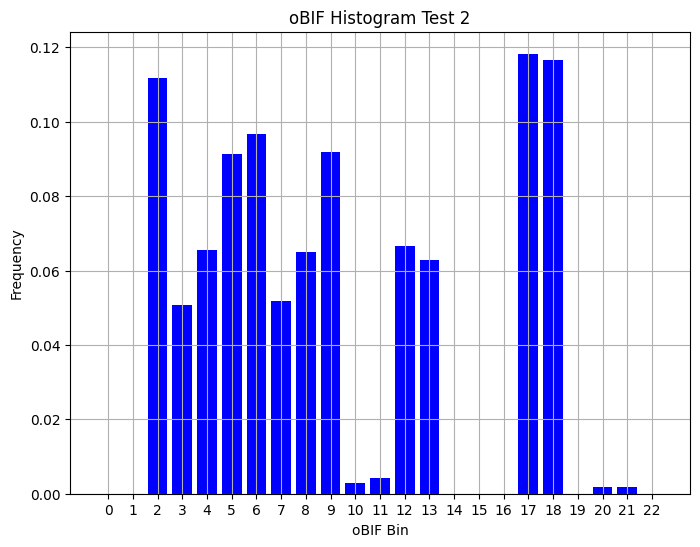

Training accuracy: 0.875
Test accuracy: 0.5


In [242]:
def mtDemoBifLab():
    """
    mtDemoBifLab
    Show oBIFs for demonstration images
    """
    im_f1 = cv2.imread("F1.jpg")
    if im_f1 is None:
        print(f"Failed to load image ")
        return
    
    im_m1 = cv2.imread("M1.jpg")
    if im_m1 is None:
        print(f"Failed to load image ")
        return
    
    im_f2 = cv2.imread("F2.jpg")
    if im_f2 is None:
        print(f"Failed to load image ")
        return
    
    im_f3 = cv2.imread("F3.jpg")
    if im_f3 is None:
        print(f"Failed to load image ")
        return
    
    im_f4 = cv2.imread("F4.jpg")
    if im_f4 is None:
        print(f"Failed to load image ")
        return
    
    im_m2 = cv2.imread("M2.jpg")
    if im_m2 is None:
        print(f"Failed to load image ")
        return
    im_m3 = cv2.imread("M3.jpg")
    if im_m3 is None:
        print(f"Failed to load image ")
        return
    im_m4 = cv2.imread("M4.jpg")
    if im_m4 is None:
        print(f"Failed to load image ")
        return
    
    img_test_1 = cv2.imread("test_1.jpg")
    if img_test_1 is None:
        print(f"Failed to load image ")
        return
    img_test_2 = cv2.imread("test_2.jpg")
    if img_test_2 is None:
        print(f"Failed to load image ")
        return
    
    
    
    
    bifs_female_1 = mtBifs(im_f1, 2, 0.015)
    bifs_female_2 = mtBifs(im_f2, 2, 0.015)
    bifs_female_3 = mtBifs(im_f3, 2, 0.015)
    bifs_female_4 = mtBifs(im_f4, 2, 0.015)

    bifs_male_1 = mtBifs(im_m1, 2, 0.015)
    bifs_male_2 = mtBifs(im_m2, 2, 0.015)
    bifs_male_3 = mtBifs(im_m3, 2, 0.015)
    bifs_male_4 = mtBifs(im_m4, 2, 0.015)

    bifs_test_1 = mtBifs(img_test_1, 2, 0.015)
    bifs_test_2 = mtBifs(img_test_2, 2, 0.015)


    

    # Assuming 'bif_obj' is an instance of mtBifs class
    histogram_f1 = bifs_female_1.generate_histogram()
    histogram_f2 = bifs_female_2.generate_histogram()
    histogram_f3 = bifs_female_3.generate_histogram()
    histogram_f4 = bifs_female_4.generate_histogram()

    histogram_test_1 = bifs_test_1.generate_histogram()
    histogram_test_2 = bifs_test_2.generate_histogram()




    # Plot the histogram
    plt.figure(figsize=(8, 6))
    plt.bar(range(len(histogram_f1)), histogram_f1, color="blue")
    plt.xlabel("oBIF Bin")
    plt.ylabel("Frequency")
    plt.title("oBIF Histogram Female 1")
    plt.xticks(range(len(histogram_f1)))
    plt.grid(True)
    plt.show()
     # Plot the histogram
    plt.figure(figsize=(8, 6))
    plt.bar(range(len(histogram_f2)), histogram_f2, color="blue")
    plt.xlabel("oBIF Bin")
    plt.ylabel("Frequency")
    plt.title("oBIF Histogram Female 2")
    plt.xticks(range(len(histogram_f2)))
    plt.grid(True)
    plt.show()
     # Plot the histogram
    plt.figure(figsize=(8, 6))
    plt.bar(range(len(histogram_f3)), histogram_f3, color="blue")
    plt.xlabel("oBIF Bin")
    plt.ylabel("Frequency")
    plt.title("oBIF Histogram Female 3")
    plt.xticks(range(len(histogram_f3)))
    plt.grid(True)
    plt.show()

 # Plot the histogram
    plt.figure(figsize=(8, 6))
    plt.bar(range(len(histogram_f4)), histogram_f4, color="blue")
    plt.xlabel("oBIF Bin")
    plt.ylabel("Frequency")
    plt.title("oBIF Histogram Female 4")
    plt.xticks(range(len(histogram_f4)))
    plt.grid(True)
    plt.show()

    histogram_m1 = bifs_male_1.generate_histogram()
    histogram_m2 = bifs_male_2.generate_histogram()
    histogram_m3 = bifs_male_3.generate_histogram()
    histogram_m4 = bifs_male_4.generate_histogram()


    # Plot the histogram
    plt.figure(figsize=(8, 6))
    plt.bar(range(len(histogram_m1)), histogram_m1, color="blue")
    plt.xlabel("oBIF Bin")
    plt.ylabel("Frequency")
    plt.title("oBIF Histogram Male 1")
    plt.xticks(range(len(histogram_m1)))
    plt.grid(True)
    plt.show()
       # Plot the histogram
    plt.figure(figsize=(8, 6))
    plt.bar(range(len(histogram_m2)), histogram_m2, color="blue")
    plt.xlabel("oBIF Bin")
    plt.ylabel("Frequency")
    plt.title("oBIF Histogram Male 2")
    plt.xticks(range(len(histogram_m2)))
    plt.grid(True)
    plt.show()

    # Plot the histogram
    plt.figure(figsize=(8, 6))
    plt.bar(range(len(histogram_m3)), histogram_m3, color="blue")
    plt.xlabel("oBIF Bin")
    plt.ylabel("Frequency")
    plt.title("oBIF Histogram Male 3")
    plt.xticks(range(len(histogram_m3)))
    plt.grid(True)
    plt.show()

    # Plot the histogram
    plt.figure(figsize=(8, 6))
    plt.bar(range(len(histogram_m4)), histogram_m4, color="blue")
    plt.xlabel("oBIF Bin")
    plt.ylabel("Frequency")
    plt.title("oBIF Histogram Male 4")
    plt.xticks(range(len(histogram_m4)))
    plt.grid(True)
    plt.show()

    # Plot the histogram
    plt.figure(figsize=(8, 6))
    plt.bar(range(len(histogram_test_1)), histogram_test_1, color="blue")
    plt.xlabel("oBIF Bin")
    plt.ylabel("Frequency")
    plt.title("oBIF Histogram Test 1")
    plt.xticks(range(len(histogram_test_1)))
    plt.grid(True)
    plt.show()
    
    # Plot the histogram
    plt.figure(figsize=(8, 6))
    plt.bar(range(len(histogram_test_2)), histogram_test_2, color="blue")
    plt.xlabel("oBIF Bin")
    plt.ylabel("Frequency")
    plt.title("oBIF Histogram Test 2")
    plt.xticks(range(len(histogram_test_2)))
    plt.grid(True)
    plt.show()


    

    

      

    labels = ['F', 'F', 'F', 'F', 'M', 'M', 'M', 'M']
    clf = train_svm(histogram_f1,histogram_f2,histogram_f3,histogram_f4, histogram_m1,histogram_m2,histogram_m3,histogram_m4, labels)
    test_svm(clf, [histogram_test_1, histogram_test_2], ['F', 'M'])

    # rounded_Vx = np.round(bifs.Vx, 1)
    # unique, counts = np.unique(rounded_Vx, return_counts=True)
    # counter = dict(zip(unique, counts))
    # print(counter)
    



# Example usage
mtDemoBifLab()
